### Group Project: Dynamic Pricing Strategies for Short-Term Rental Listings: An Integrated Empirical and Analytical Approach - Dynamic Revenue Management for Urban Rental Markets through the Airbnb scraped data of Chicago 2017

#### Step 0: Package importation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import datetime
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

#### Step 1: DATA LOADING, CLEANING, & FEATURE ENGINEERING

We began our data preparation process by loading the listings and neighbourhoods datasets from their respective CSV files. We checked the dataset dimensions and removed duplicate rows to maintain data quality. Next, we ensured that the price data was in numeric format by stripping out dollar signs and commas, and created a new feature, amenities_count, by counting the number of comma-separated amenities available for each listing. To address the occupancy data, if the 'booked' indicator was missing, we simulated it using a binomial distribution with a 60% success rate. Finally, we handled missing values for key features (such as bedrooms and bathrooms) by filling them with the median values, and we merged the listings with the neighbourhood data to ensure that each listing had an associated

In [2]:
import pandas as pd
import numpy as np

# File path for listings data
listings_file = 'listings.csv'

# Load data
listings_df = pd.read_csv(listings_file)
print("Listings shape:", listings_df.shape)

# Remove duplicate rows
listings_df.drop_duplicates(inplace=True)

# Convert 'price' to numeric (remove "$" and commas if needed)
if listings_df['price'].dtype == object:
    listings_df['price'] = listings_df['price'].str.replace(r"[\$,]", "", regex=True).astype(float)

# Create numeric feature for amenities count (assume a comma‑separated string)
if 'amenities' in listings_df.columns:
    listings_df['amenities_count'] = listings_df['amenities'].apply(
        lambda x: len(x.split(',')) if isinstance(x, str) else 0)
else:
    listings_df['amenities_count'] = 0

# Ensure occupancy indicator exists; if missing, simulate it
if 'booked' not in listings_df.columns:
    np.random.seed(42)
    listings_df['booked'] = np.random.binomial(1, 0.6, listings_df.shape[0])

# Fill missing values for key features (bedrooms, bathrooms)
for col in ['bedrooms', 'bathrooms']:
    if col in listings_df.columns:
        listings_df[col].fillna(listings_df[col].median(), inplace=True)
    else:
        listings_df[col] = 0

# Display missing value counts
key_columns = ['bedrooms', 'bathrooms', 'amenities_count', 'price']
print("\nMissing values before cleaning:")
print(listings_df[key_columns].isnull().sum())

print("\nMissing values after cleaning:")
print(listings_df[key_columns].isnull().sum())


Listings shape: (5207, 95)

Missing values before cleaning:
bedrooms           0
bathrooms          0
amenities_count    0
price              0
dtype: int64

Missing values after cleaning:
bedrooms           0
bathrooms          0
amenities_count    0
price              0
dtype: int64


#### Step 2:  PER‑NEIGHBOURHOOD CLUSTERING (2 Clusters per Neighbourhood)

We started by extracting the unique neighbourhoods from our listings data to identify distinct segments for analysis. For each neighbourhood with at least three listings, we applied K-Means clustering on key features ('bedrooms', 'entire_home', 'cleaning_fee', 'has_kitchen') to segment the listings into two clusters. The results for each neighbourhood were stored in dictionaries: one for the detailed DataFrame with cluster assignments and another for summary statistics per cluster (including count, median price, occupancy rate, and mean values of bedrooms, bathrooms, and amenities). Finally, we printed the summary for each neighbourhood, which helps us better understand the property attributes and booking behavior across different segments.

In [3]:
# Feature engineering for clustering
# Binary indicator for entire home/apt
if 'room_type' in listings_df.columns:
    listings_df['entire_home'] = (listings_df['room_type'] == 'Entire home/apt').astype(int)
else:
    listings_df['entire_home'] = 0

# Ensure cleaning_fee column exists, convert to numeric, and fill missing
if 'cleaning_fee' not in listings_df.columns:
    listings_df['cleaning_fee'] = 0.0
else:
    if listings_df['cleaning_fee'].dtype == object:
        listings_df['cleaning_fee'] = listings_df['cleaning_fee'].str.replace(r"[\$,]", "", regex=True).astype(float)
    listings_df['cleaning_fee'].fillna(0.0, inplace=True)

# Binary indicator for presence of 'Kitchen' in amenities
if 'amenities' in listings_df.columns:
    listings_df['has_kitchen'] = listings_df['amenities'].str.contains('Kitchen', na=False).astype(int)
else:
    listings_df['has_kitchen'] = 0

# Clustering by neighbourhood (if column exists)
if 'neighbourhood' in listings_df.columns:
    # Exclude missing neighbourhoods
    unique_neighbourhoods = listings_df['neighbourhood'].dropna().unique()
    print("\nUnique neighbourhoods in the data:")
    print(unique_neighbourhoods)

    neighbourhood_clusters = {}
    neighbourhood_cluster_summary = {}

    for nb in unique_neighbourhoods:
        df_nb = listings_df[listings_df['neighbourhood'] == nb].copy()
        if df_nb.shape[0] < 3:
            print(f"Neighbourhood '{nb}': Not enough data for clustering.")
            continue

        # Select clustering features and drop any remaining NaNs
        features = ['bedrooms', 'entire_home', 'cleaning_fee', 'has_kitchen']
        df_nb = df_nb.dropna(subset=features)
        X = df_nb[features]

        # Apply K-Means clustering with 2 clusters
        kmeans = KMeans(n_clusters=2, random_state=42)
        df_nb['cluster'] = kmeans.fit_predict(X)
        neighbourhood_clusters[nb] = df_nb

        # Summary statistics per cluster
        summary = df_nb.groupby('cluster').agg(
            count=('price', 'count'),
            median_price=('price', 'median'),
            avg_occupancy=('booked', 'mean'),
            mean_entire_home=('entire_home', 'mean'),
            mean_bathrooms=('bathrooms', 'mean'),
            mean_cleaning_fee=('cleaning_fee', 'mean'),
            mean_has_kitchen=('has_kitchen', 'mean')
        ).reset_index()
        neighbourhood_cluster_summary[nb] = summary

        print(f"\n--- Neighbourhood: {nb} ---")
        print(summary)
else:
    print("Column 'neighbourhood' not found; skipping clustering stage.")



Unique neighbourhoods in the data:
['Lincoln Square' 'Uptown' 'Hyde Park' 'Woodlawn' 'Rogers Park'
 'Jefferson Park' 'Sauganash' 'North Park' 'Albany Park' 'Dunning'
 'West Ridge' 'Avondale' 'Bucktown' 'Logan Square' 'Lincoln Park'
 'Wicker Park' 'Humboldt Park' 'West Town/Noble Square' 'River West'
 'Ukrainian Village' 'West Town' 'Loop' 'Galewood' 'Austin'
 'Little Italy/UIC' 'West Loop/Greektown' 'Near West Side' 'Andersonville'
 'Lakeview' 'South Loop/Printers Row' 'Norwood Park' 'Near North Side'
 'River North' 'Gold Coast' 'Old Town' 'Streeterville' 'North Center'
 'Magnificent Mile' 'Printers Row' 'South Shore' 'South Chicago'
 'South Deering' 'Garfield Ridge' 'Back of the Yards' 'Wrigleyville'
 'Boystown' 'Roscoe Village' 'Montclare' 'Clearing' 'Grand Crossing'
 'Ashburn' "O'Hare" 'Edgewater' 'Bronzeville' 'Oakland' 'Archer Heights'
 'Kenwood' 'Washington Park' 'Portage Park' 'Irving Park' 'Belmont Cragin'
 'Hermosa' 'Garfield Park' 'North Lawndale' 'Little Village' 'Pilsen'
 

#### Step 3: 3. DEMAND,PROFIT MODEL FUNCTIONS & ELASTICITY

We defined:

- demand_probability(x, x_mid, steepness):
Computes the booking probability via a logistic (sigmoid) curve, where

x_mid is the price at which the booking probability is 50%, and

steepness controls how sensitive demand is to price changes.

- profit_function(x, x_mid, steepness, C_v):
Takes the booking probability and multiplies it by the net revenue per booking (price minus variable cost), giving expected profit at each price.

- elasticity_function(x, x_mid, steepness):
Calculates the point price elasticity of demand, which tells us the percent change in booking probability for a one‑percent change in price—critical for understanding how responsive each cluster is to price moves.

Together, these three functions let us:

1. Forecast demand at any price,

2. Optimize profit by finding the price that maximizes expected revenue, and

3. Gauge sensitivity via elasticity curves—key for tailoring both static and dynamic strategies to segments with different price‑responsiveness.

In [4]:
def demand_probability(x, x_mid, steepness):
    """
    Logistic demand function.
    x_mid: price at which booking probability is 50%.
    steepness: sensitivity of demand.
    """
    return 1.0 / (1.0 + np.exp(steepness * (x - x_mid)))

def profit_function(x, x_mid, steepness, Cv):
    """
    Profit function: profit = demand_probability(x) * (x - variable cost).
    Cv: variable cost per booking.
    """
    return demand_probability(x, x_mid, steepness) * (x - Cv)

def elasticity(x, x_mid, steepness):
    """
    Own‑price elasticity for a logistic demand curve:
      ε(x) = (dD/dx) * (x / D)
           = [−γ·D·(1−D)]·(x/D)
           = −γ·x·(1−D)
    """
    D = demand_probability(x, x_mid, steepness)
    return -steepness * x * (1.0 - D)



#### Step 4: STATIC PARAMETERS & CURVES PER (Neighbourhood, Cluster)

In this section, we set up key parameters for our pricing model, including a sensitivity factor (steepness = 0.05), a variable cost per booking (Cv = 50.0), and a price grid spanning 50 to 250. We then calculate the overall occupancy rate from the bookings data and initialize a dictionary, pricing_params, which will store our computed pricing parameters for each neighbourhood–cluster combination. For each neighbourhood, we iterate over its clustering summary and compute a modified price parameter (base_x_mid) by shifting the median price based on the difference between the cluster’s occupancy rate and the overall occupancy. Using our demand and profit functions, we obtain arrays of demand probabilities and expected profits across the price grid, identify the price that maximizes profit (the static optimal price), and store all these computed values in the dictionary. Finally, the code prints out a summary of the key pricing metrics for each neighbourhood–cluster pairing.

In [5]:
steepness = 0.05       # Sensitivity factor
Cv = 50.0              # Variable cost per booking
price_range = np.linspace(50, 250, 300)  # Price grid
overall_occupancy = listings_df['booked'].mean()

pricing_params = {}

for nb, df_nb in neighbourhood_clusters.items():
    summary_df = neighbourhood_cluster_summary[nb]
    for _, row in summary_df.iterrows():
        cluster_id    = row['cluster']
        median_price  = row['median_price']
        occ_rate      = row['avg_occupancy']
        base_x_mid    = median_price * (1 + (occ_rate - overall_occupancy))
        demand_vals   = demand_probability(price_range, base_x_mid, steepness)
        profit_vals   = profit_function(price_range, base_x_mid, steepness, Cv)
        idx           = np.argmax(profit_vals)
        static_price  = price_range[idx]
        static_profit = profit_vals[idx]

        #--- New: compute elasticity curves for all 4 strategies:
        ell_static   = elasticity(price_range, base_x_mid, steepness)
        ell_seasonal = elasticity(price_range, base_x_mid * 1.10, steepness)
        ell_weekend  = elasticity(price_range, base_x_mid * 1.05, steepness)
        ell_hybrid   = elasticity(price_range, base_x_mid * 1.15, steepness)

        pricing_params[(nb, cluster_id)] = {
            'median_price':           median_price,
            'occupancy_rate':         occ_rate,
            'base_x_mid':             base_x_mid,
            'demand_values':          demand_vals,
            'profit_values':          profit_vals,
            'static_optimal_price':   static_price,
            'static_optimal_profit':  static_profit,
            # ← these four new fields:
            'elasticity_static':      ell_static,
            'elasticity_seasonal':    ell_seasonal,
            'elasticity_weekend':     ell_weekend,
            'elasticity_hybrid':      ell_hybrid
        }

        print(f"\nNeighbourhood: {nb} – Cluster: {cluster_id}")
        print(f"  Median Price: ${median_price:.2f}")
        print(f"  Occupancy Rate: {occ_rate:.3f}")
        print(f"  Base x_mid: ${base_x_mid:.2f}")
        print(f"  Static Optimal Price: ${static_price:.2f}")
        print(f"  Profit at Optimal Price: ${static_profit:.2f}")



Neighbourhood: Lincoln Square – Cluster: 0.0
  Median Price: $142.00
  Occupancy Rate: 0.483
  Base x_mid: $125.33
  Static Optimal Price: $110.87
  Profit at Optimal Price: $40.98

Neighbourhood: Lincoln Square – Cluster: 1.0
  Median Price: $80.00
  Occupancy Rate: 0.675
  Base x_mid: $85.99
  Static Optimal Price: $88.13
  Profit at Optimal Price: $18.04

Neighbourhood: Uptown – Cluster: 0.0
  Median Price: $75.00
  Occupancy Rate: 0.680
  Base x_mid: $81.01
  Static Optimal Price: $85.45
  Profit at Optimal Price: $15.77

Neighbourhood: Uptown – Cluster: 1.0
  Median Price: $156.00
  Occupancy Rate: 0.469
  Base x_mid: $135.50
  Static Optimal Price: $118.23
  Profit at Optimal Price: $47.99

Neighbourhood: Hyde Park – Cluster: 0.0
  Median Price: $120.00
  Occupancy Rate: 0.769
  Base x_mid: $140.29
  Static Optimal Price: $121.57
  Profit at Optimal Price: $51.41

Neighbourhood: Hyde Park – Cluster: 1.0
  Median Price: $70.00
  Occupancy Rate: 0.582
  Base x_mid: $68.74
  Static

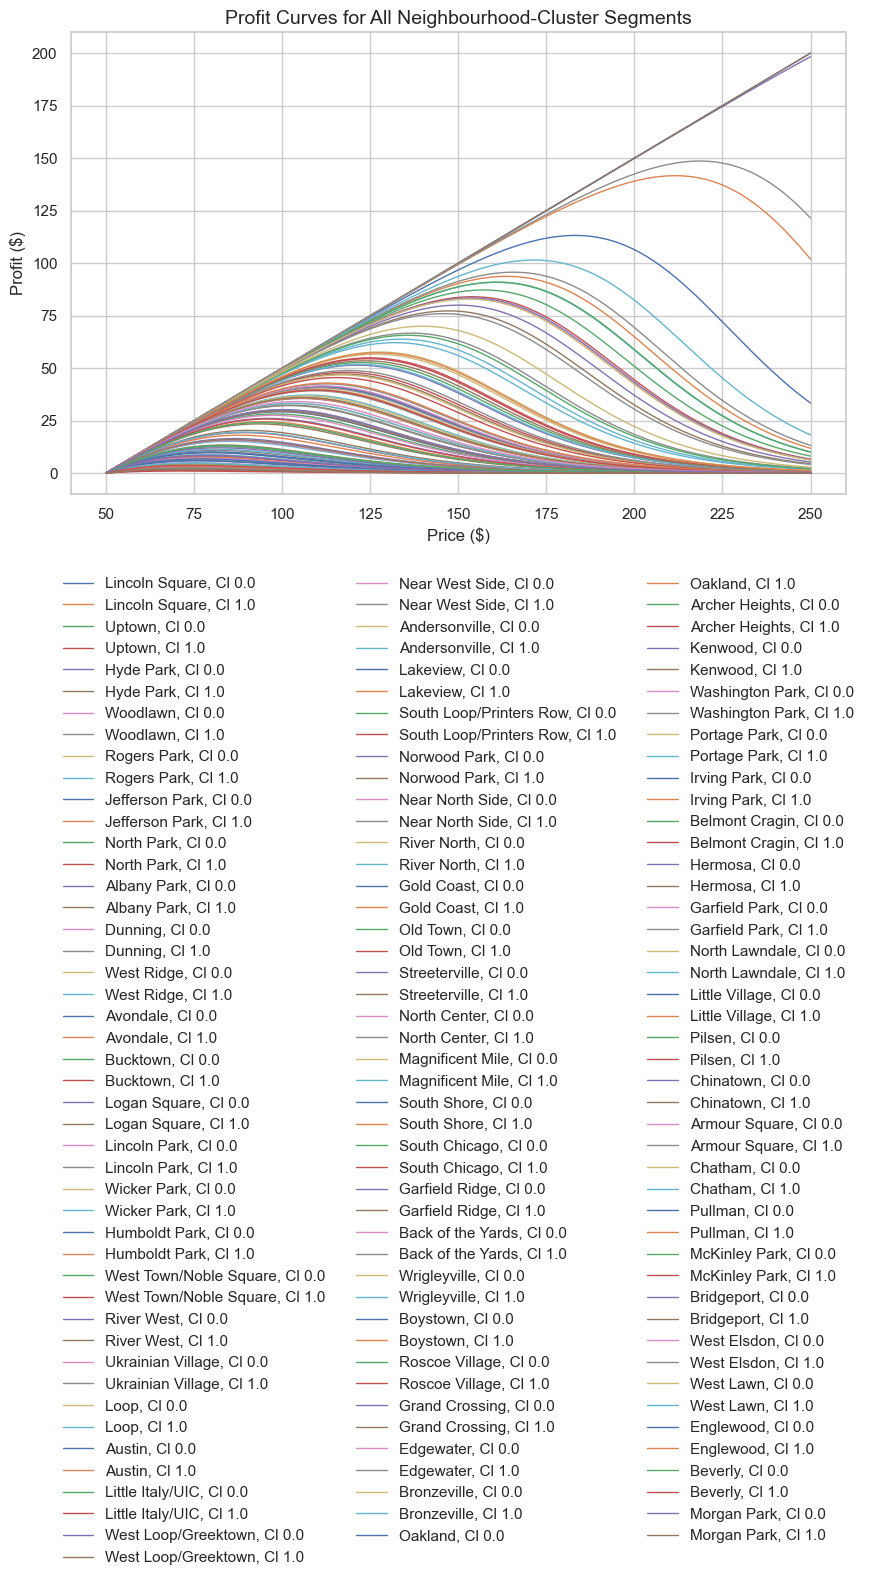

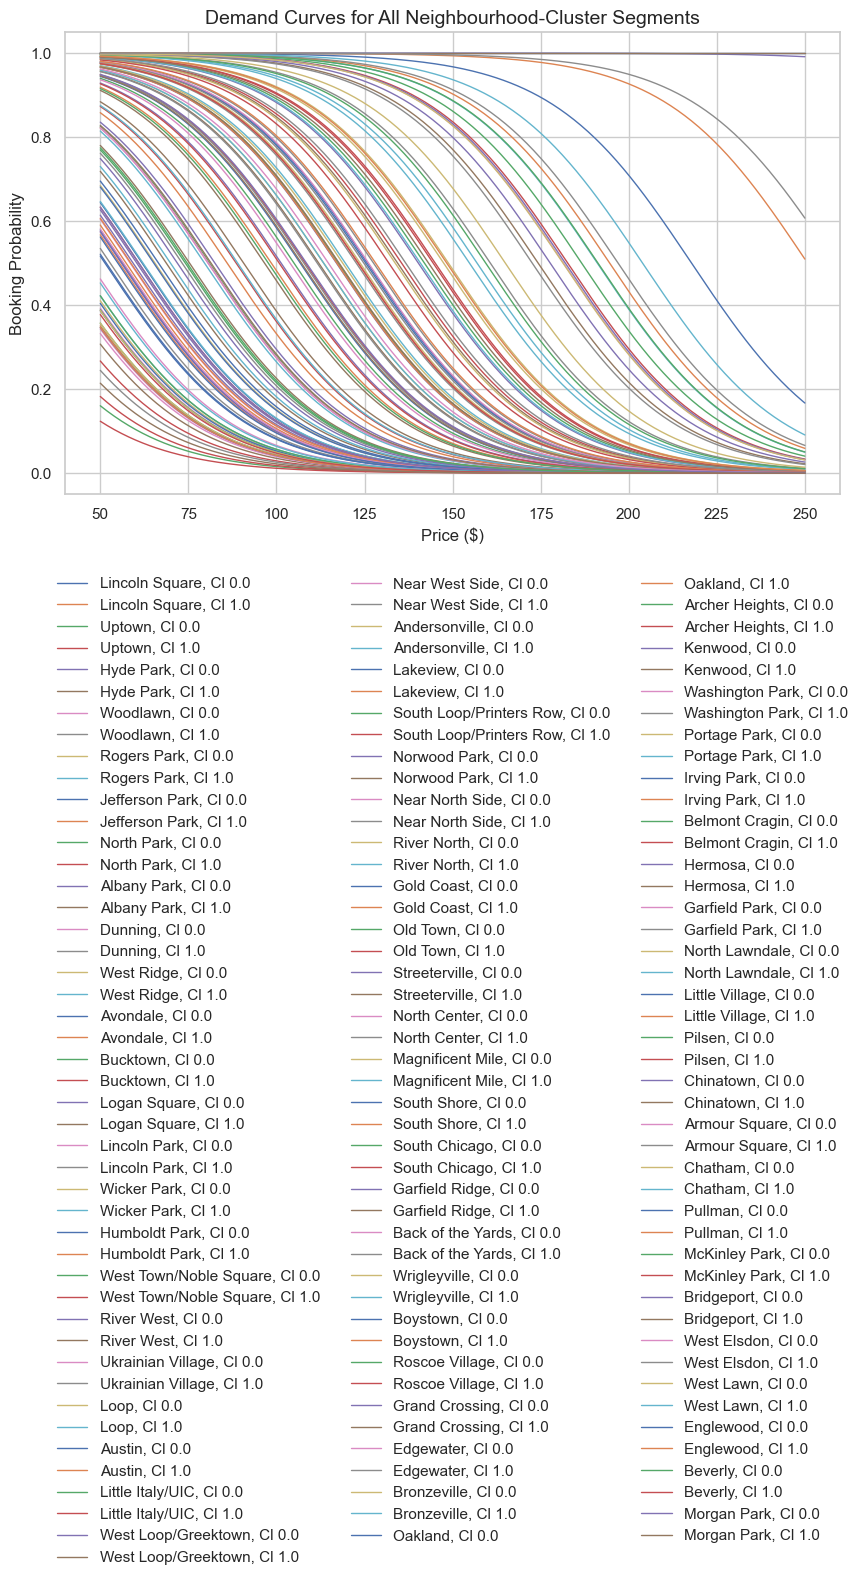

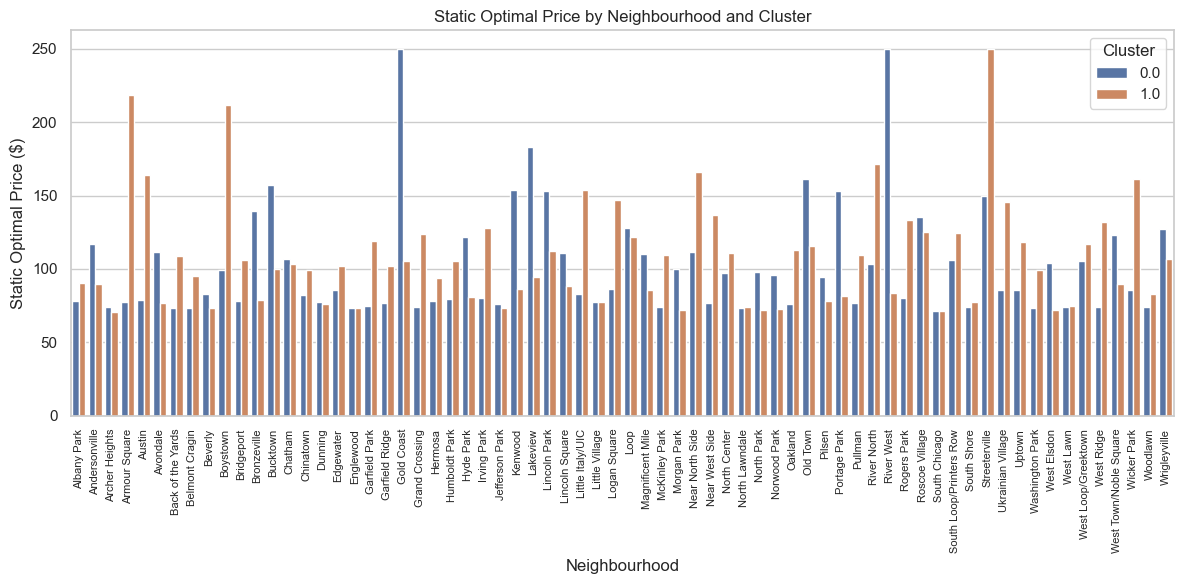

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 1) PROFIT CURVES FOR ALL NEIGHBOURHOOD-CLUSTER SEGMENTS
fig_profit, ax_profit = plt.subplots(figsize=(10, 6))

for (nb, cluster_id), params in pricing_params.items():
    label_str = f"{nb}, Cl {cluster_id}"
    ax_profit.plot(price_range, params['profit_values'], label=label_str, lw=1)

ax_profit.set_xlabel("Price ($)", fontsize=12)
ax_profit.set_ylabel("Profit ($)", fontsize=12)
ax_profit.set_title("Profit Curves for All Neighbourhood-Cluster Segments", fontsize=14)

# Legend placed below the plot.
ax_profit.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.tight_layout()
plt.show()

# 2) DEMAND CURVES FOR ALL NEIGHBOURHOOD-CLUSTER SEGMENTS
fig_demand, ax_demand = plt.subplots(figsize=(10, 6))

for (nb, cluster_id), params in pricing_params.items():
    label_str = f"{nb}, Cl {cluster_id}"
    ax_demand.plot(price_range, params['demand_values'], label=label_str, lw=1)

ax_demand.set_xlabel("Price ($)", fontsize=12)
ax_demand.set_ylabel("Booking Probability", fontsize=12)
ax_demand.set_title("Demand Curves for All Neighbourhood-Cluster Segments", fontsize=14)

# Adjust legend placement to be below the plot as well.
ax_demand.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.tight_layout()
plt.show()

# Create a DataFrame from pricing_params for easier plotting
opt_data = []
for key, params in pricing_params.items():
    nb, clust = key
    opt_data.append({
        'Neighbourhood': nb,
        'Cluster': clust,
        'Optimal Price': params['static_optimal_price'],
        'Optimal Profit': params['static_optimal_profit']
    })
opt_df = pd.DataFrame(opt_data)

# Sort the data frame for better plotting (optional)
opt_df = opt_df.sort_values(by=['Neighbourhood', 'Cluster'])

plt.figure(figsize=(12, 6))
sns.barplot(data=opt_df, x='Neighbourhood', y='Optimal Price', hue='Cluster')
plt.xlabel("Neighbourhood")
plt.ylabel("Static Optimal Price ($)")
plt.title("Static Optimal Price by Neighbourhood and Cluster")
plt.xticks(rotation=90, fontsize=8)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

#### Step 5: DEFINE DYNAMIC ADJUSTMENT FACTORS

We implemented two functions to adjust pricing based on time-related factors. The seasonal_factor function uses a sine curve to simulate seasonal variations in demand with an amplitude of 10%, peaking around mid-July (approximately day 200 of the year). The function converts the input date to the day of the year and applies the sine transformation to generate the adjustment factor. In addition, the weekend_factor function applies a 5% demand boost if the provided date falls on a weekend (Saturday or Sunday), returning 0% otherwise. These adjustments help refine our pricing strategy to account for predictable fluctuations in booking demand over time.








In [7]:
def seasonal_factor(date):
    """
    Seasonal adjustment factor using a sine curve.
    Assumes peak demand (+10%) around mid-July.
    """
    day_of_year = date.timetuple().tm_yday
    amplitude = 0.10
    return amplitude * np.sin(2 * np.pi * (day_of_year - 200) / 365)

def weekend_factor(date):
    """
    Weekend adjustment factor: +5% on weekends.
    """
    return 0.05 if date.weekday() >= 5 else 0.0

#### Step 6: DYNAMIC PRICING SIMULATION OVER ONE YEAR (365 Days)

We first establish a date range beginning on May 10, 2017, to represent one full year of daily data. Using this date range, we define four pricing strategies—Static, Seasonal Dynamic, Weekend Dynamic, and Hybrid Dynamic—to simulate daily optimal pricing and profits. For each neighbourhood–cluster combination stored in our pricing parameters, we create a DataFrame with a 'Date' column and initialize new columns for each strategy’s optimal price and profit. Then, for each day, we compute the optimal static profit (without any adjustments), and we recalculate the optimal pricing for the seasonal adjustment (using a sine curve to model seasonal changes), the weekend adjustment (applying a flat increase for weekends), and a hybrid of both adjustments. Finally, we store the daily simulation results in the dynamic_results dictionary so that we can analyze the cumulative annual performance of each pricing strategy across different neighbourhood clusters.



In [8]:
start_date = datetime.date(2017, 5, 10)  # Actual data scraping date
dates = pd.date_range(start=start_date, periods=365)
strategies = ['Static', 'Seasonal Dynamic', 'Weekend Dynamic', 'Hybrid Dynamic']
dynamic_results = {}  # key: (neighbourhood, cluster), value: daily DataFrame

for key, params in pricing_params.items():
    nb, cluster_id = key
    base_x_mid = params['base_x_mid']
    static_price = params['static_optimal_price']

    daily_data = pd.DataFrame({'Date': dates})
    for strat in strategies:
        daily_data[f'{strat}_Price'] = np.nan
        daily_data[f'{strat}_Profit'] = np.nan

    for i, date in enumerate(dates):
        # Static strategy: no adjustment
        static_profit = profit_function(static_price, base_x_mid, steepness, Cv)
        daily_data.loc[i, 'Static_Price'] = static_price
        daily_data.loc[i, 'Static_Profit'] = static_profit

        # Seasonal Dynamic: adjust x_mid by seasonal factor
        season_adj = 1 + seasonal_factor(date)
        x_mid_season = base_x_mid * season_adj
        profits = profit_function(price_range, x_mid_season, steepness, Cv)
        idx_opt = np.argmax(profits)
        daily_data.loc[i, 'Seasonal Dynamic_Price'] = price_range[idx_opt]
        daily_data.loc[i, 'Seasonal Dynamic_Profit'] = profits[idx_opt]

        # Weekend Dynamic: adjust x_mid by weekend factor
        weekend_adj = 1 + weekend_factor(date)
        x_mid_weekend = base_x_mid * weekend_adj
        profits = profit_function(price_range, x_mid_weekend, steepness, Cv)
        idx_opt = np.argmax(profits)
        daily_data.loc[i, 'Weekend Dynamic_Price'] = price_range[idx_opt]
        daily_data.loc[i, 'Weekend Dynamic_Profit'] = profits[idx_opt]

        # Hybrid Dynamic: combine seasonal and weekend adjustments
        hybrid_adj = 1 + seasonal_factor(date) + weekend_factor(date)
        x_mid_hybrid = base_x_mid * hybrid_adj
        profits = profit_function(price_range, x_mid_hybrid, steepness, Cv)
        idx_opt = np.argmax(profits)
        daily_data.loc[i, 'Hybrid Dynamic_Price'] = price_range[idx_opt]
        daily_data.loc[i, 'Hybrid Dynamic_Profit'] = profits[idx_opt]

    dynamic_results[key] = daily_data


#### Step 7: EVALUATION Average Price per  (Neighbourhood, Cluster) DYNAMIC

In [9]:
print("\n--- Dynamic Pricing Summary (Average Price) ---")
price_summary = {}

for key, daily_data in dynamic_results.items():
    nb, cluster_id = key
    summary = {}
    print(f"\nNeighbourhood: {nb} – Cluster: {cluster_id}")
    for strat in strategies:
        avg_price = daily_data[f'{strat}_Price'].mean()
        summary[strat] = avg_price
        print(f"  {strat}: Average  Price = ${avg_price:.2f}")
    price_summary[key] = summary



--- Dynamic Pricing Summary (Average Price) ---

Neighbourhood: Lincoln Square – Cluster: 0.0
  Static: Average  Price = $110.87
  Seasonal Dynamic: Average  Price = $111.12
  Weekend Dynamic: Average  Price = $112.20
  Hybrid Dynamic: Average  Price = $112.34

Neighbourhood: Lincoln Square – Cluster: 1.0
  Static: Average  Price = $88.13
  Seasonal Dynamic: Average  Price = $88.14
  Weekend Dynamic: Average  Price = $88.70
  Hybrid Dynamic: Average  Price = $88.75

Neighbourhood: Uptown – Cluster: 0.0
  Static: Average  Price = $85.45
  Seasonal Dynamic: Average  Price = $85.89
  Weekend Dynamic: Average  Price = $86.02
  Hybrid Dynamic: Average  Price = $86.42

Neighbourhood: Uptown – Cluster: 1.0
  Static: Average  Price = $118.23
  Seasonal Dynamic: Average  Price = $118.12
  Weekend Dynamic: Average  Price = $119.56
  Hybrid Dynamic: Average  Price = $119.52

Neighbourhood: Hyde Park – Cluster: 0.0
  Static: Average  Price = $121.57
  Seasonal Dynamic: Average  Price = $121.54
  

#### Step 8: EVALUATION: PRINT CUMULATIVE ANNUAL PROFITS PER (Neighbourhood, Cluster)

We first print a header to indicate that we are generating an annual summary of the dynamic pricing performance in terms of cumulative profits. For each neighbourhood–cluster combination available in our dynamic_results dictionary, we iterate over our four defined pricing strategies. Within the loop, we compute the cumulative profit by summing up the daily profit values for each strategy. Finally, we print out the cumulative annual profit for each strategy and store these summary values in the annual_summary dictionary for further analysis.

In [10]:
print("\n--- Annual Dynamic Pricing Summary (Cumulative Profit) ---")
annual_summary = {}

for key, daily_data in dynamic_results.items():
    nb, cluster_id = key
    summary = {}
    print(f"\nNeighbourhood: {nb} – Cluster: {cluster_id}")
    for strat in strategies:
        cum_profit = daily_data[f'{strat}_Profit'].sum()
        summary[strat] = cum_profit
        print(f"  {strat}: Cumulative Annual Profit = ${cum_profit:.2f}")
    annual_summary[key] = summary


--- Annual Dynamic Pricing Summary (Cumulative Profit) ---

Neighbourhood: Lincoln Square – Cluster: 0.0
  Static: Cumulative Annual Profit = $14958.33
  Seasonal Dynamic: Cumulative Annual Profit = $15010.14
  Weekend Dynamic: Cumulative Annual Profit = $15403.30
  Hybrid Dynamic: Cumulative Annual Profit = $15453.87

Neighbourhood: Lincoln Square – Cluster: 1.0
  Static: Cumulative Annual Profit = $6586.39
  Seasonal Dynamic: Cumulative Annual Profit = $6630.43
  Weekend Dynamic: Cumulative Annual Profit = $6804.68
  Hybrid Dynamic: Cumulative Annual Profit = $6848.15

Neighbourhood: Uptown – Cluster: 0.0
  Static: Cumulative Annual Profit = $5754.93
  Seasonal Dynamic: Cumulative Annual Profit = $5796.39
  Weekend Dynamic: Cumulative Annual Profit = $5946.53
  Hybrid Dynamic: Cumulative Annual Profit = $5987.51

Neighbourhood: Uptown – Cluster: 1.0
  Static: Cumulative Annual Profit = $17517.50
  Seasonal Dynamic: Cumulative Annual Profit = $17568.97
  Weekend Dynamic: Cumulative A

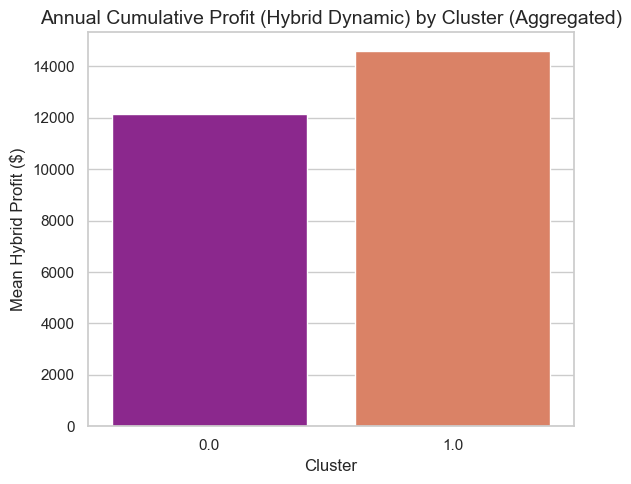

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visual 2: Annual Cumulative Profit using Hybrid Dynamic Pricing, Aggregated by Cluster
# 1. Convert annual_summary to a DataFrame
profit_data = []
for (nb, clust), summary in annual_summary.items():
    profit_data.append({
        'Neighbourhood': nb,
        'Cluster': clust,
        'HybridProfit': summary['Hybrid Dynamic']
    })

df_profit = pd.DataFrame(profit_data)

# 2. Aggregate across neighbourhoods to get mean Hybrid Profit by cluster.
agg_profit = (
    df_profit
    .groupby('Cluster', as_index=False)['HybridProfit']
    .mean()           # or use .sum() if you want total
    .rename(columns={'HybridProfit': 'MeanHybridProfit'})
)

# 3. Plot a bar chart showing the aggregated Hybrid profit by cluster.
plt.figure(figsize=(6, 5))
sns.barplot(data=agg_profit, x='Cluster', y='MeanHybridProfit', palette='plasma')
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Mean Hybrid Profit ($)", fontsize=12)
plt.title("Annual Cumulative Profit (Hybrid Dynamic) by Cluster (Aggregated)", fontsize=14)
plt.tight_layout()
plt.show()


#### Step 9: SELECTED VISUALIZATION FOR 3 NEIGHBOURHOODS

In this section, we first select three neighbourhoods—Lincoln Square, Uptown, and Hyde Park—to capture diverse market dynamics. For these areas, we produce two consolidated visualizations:

Dynamic visualization (Part A): a multi‑panel time‑series plot of the daily evolution of the hybrid dynamic price and profit for each cluster, illustrating how our seasonal and weekend adjustments drive third‑degree discrimination over a one‑year horizon.

Elasticity visualization (Part B): overlayed price‑elasticity curves for all four strategies—static, seasonal dynamic, weekend dynamic, and hybrid dynamic—showing how booking probability responds to price changes under each policy.

These visualizations enable us to compare dynamic performance across clusters and to understand the underlying demand sensitivity, offering a comprehensive view of optimal pricing strategies for each segment.



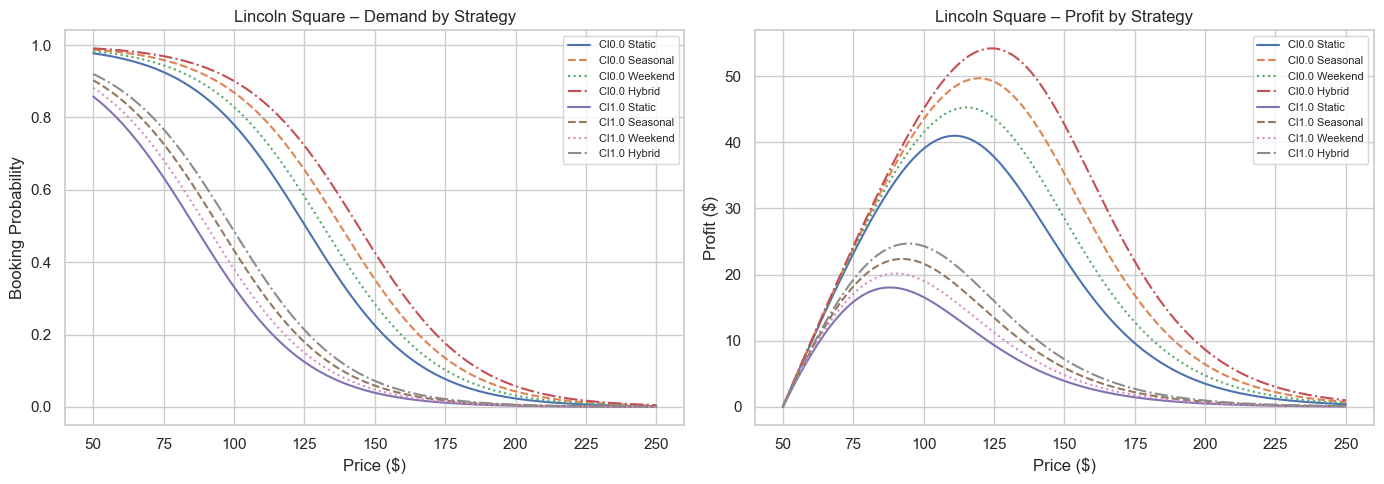

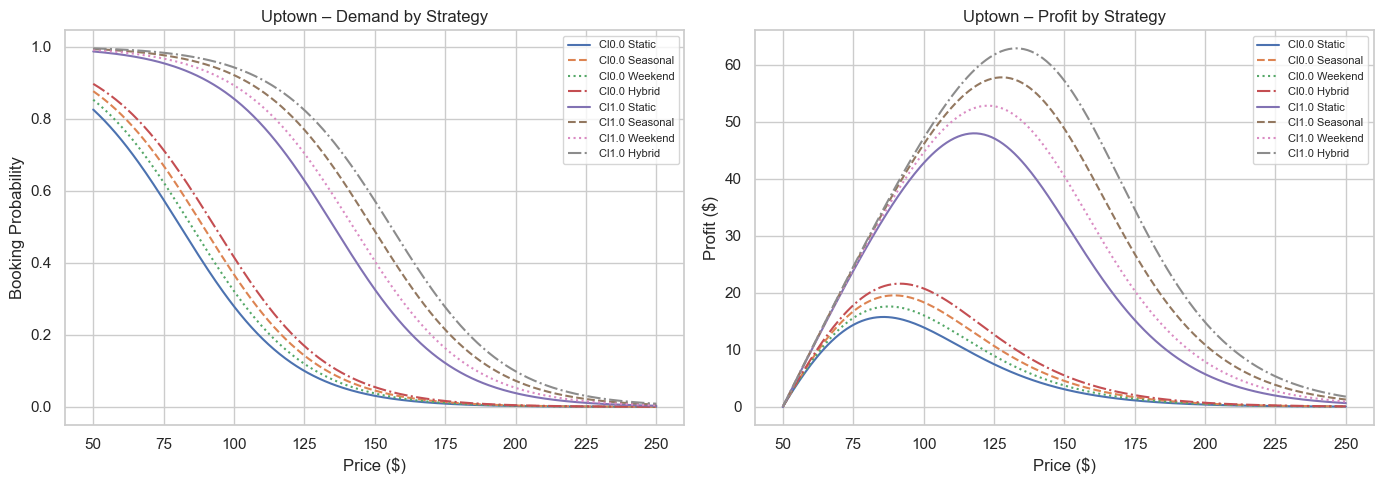

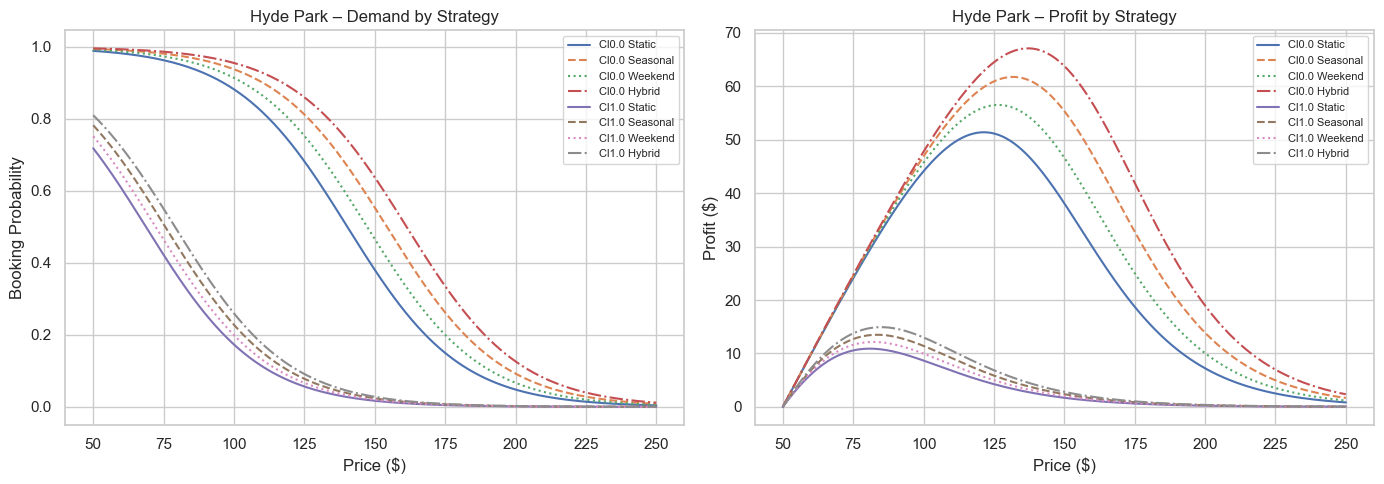

In [13]:
# Here we choose 3 neighbourhoods with diverse characteristics.
# You can change this list as needed.
#Price and demand curve
selected_neighbourhoods = ["Lincoln Square", "Uptown", "Hyde Park"]

for nb in selected_neighbourhoods:
    fig, (ax_d, ax_p) = plt.subplots(1, 2, figsize=(14,5), sharex=True)

    # Demand curves
    for (n, cl), params in pricing_params.items():
        if n != nb: continue
        x_mid = params['base_x_mid']
        ax_d.plot(price_range, params['demand_values'],          label=f'Cl{cl} Static', lw=1.5)
        ax_d.plot(price_range, demand_probability(price_range, x_mid*1.10, steepness),
                  label=f'Cl{cl} Seasonal',   lw=1.5, ls='--')
        ax_d.plot(price_range, demand_probability(price_range, x_mid*1.05, steepness),
                  label=f'Cl{cl} Weekend',    lw=1.5, ls=':')
        ax_d.plot(price_range, demand_probability(price_range, x_mid*1.15, steepness),
                  label=f'Cl{cl} Hybrid',     lw=1.5, ls='-.')

    ax_d.set_title(f"{nb} – Demand by Strategy")
    ax_d.set_xlabel("Price ($)")
    ax_d.set_ylabel("Booking Probability")
    ax_d.grid(True)
    ax_d.legend(fontsize=8)

    # Profit curves
    for (n, cl), params in pricing_params.items():
        if n != nb: continue
        x_mid = params['base_x_mid']
        ax_p.plot(price_range, params['profit_values'],           label=f'Cl{cl} Static', lw=1.5)
        ax_p.plot(price_range, profit_function(price_range, x_mid*1.10, steepness, Cv),
                  label=f'Cl{cl} Seasonal',   lw=1.5, ls='--')
        ax_p.plot(price_range, profit_function(price_range, x_mid*1.05, steepness, Cv),
                  label=f'Cl{cl} Weekend',    lw=1.5, ls=':')
        ax_p.plot(price_range, profit_function(price_range, x_mid*1.15, steepness, Cv),
                  label=f'Cl{cl} Hybrid',     lw=1.5, ls='-.')

    ax_p.set_title(f"{nb} – Profit by Strategy")
    ax_p.set_xlabel("Price ($)")
    ax_p.set_ylabel("Profit ($)")
    ax_p.grid(True)
    ax_p.legend(fontsize=8)

    plt.tight_layout()
    plt.show()


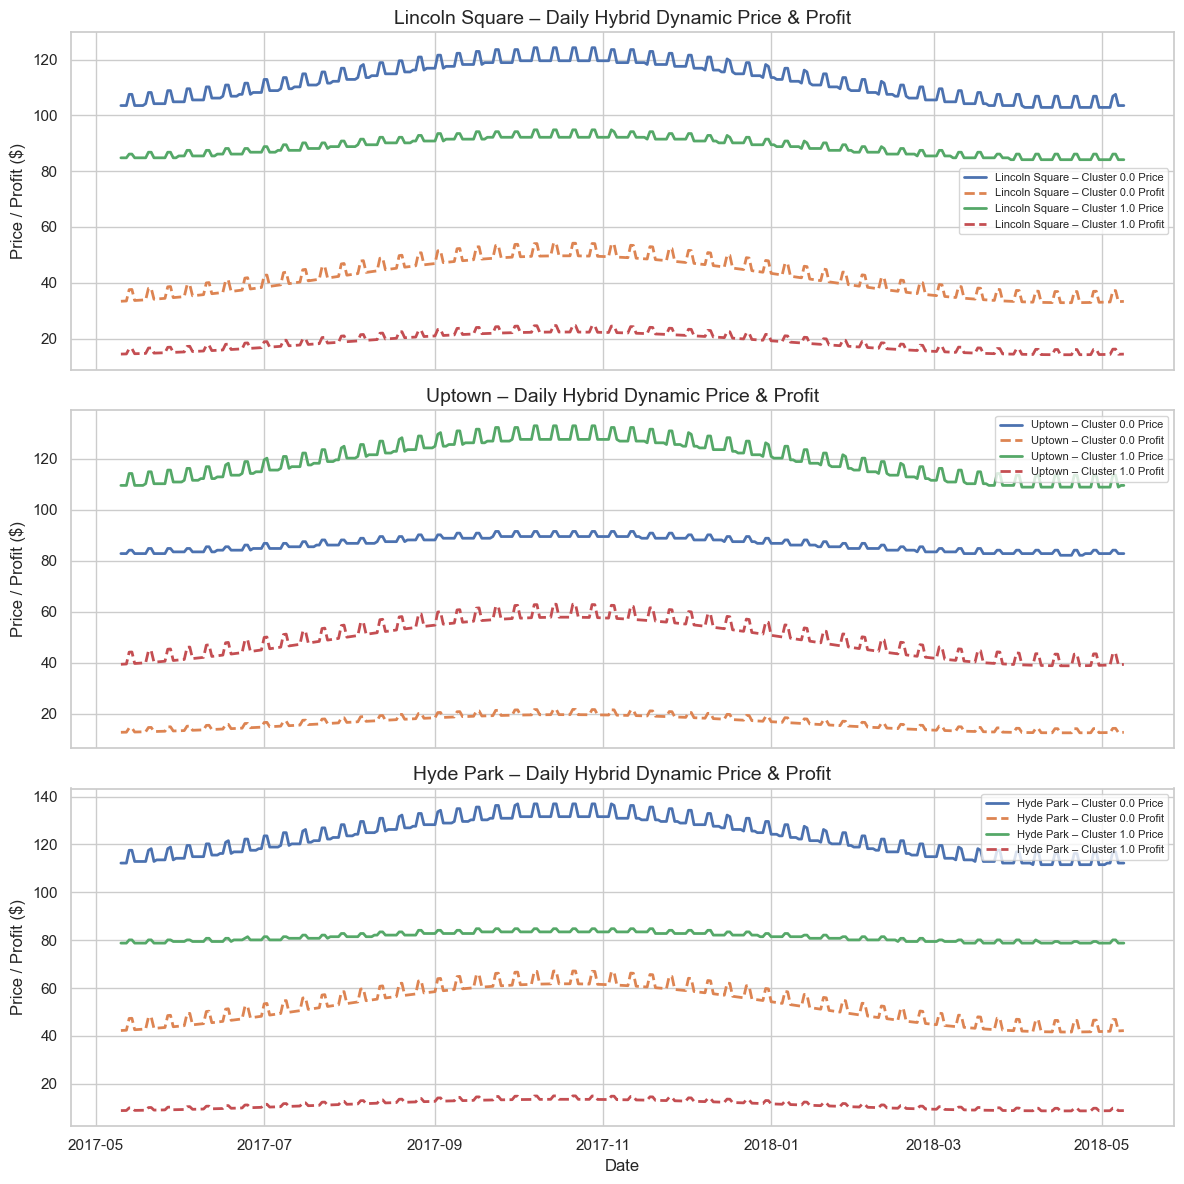

In [14]:
# Here we choose 3 neighbourhoods with diverse characteristics.
# You can change this list as needed.
#price and profit visualisation
selected_neighbourhoods = ["Lincoln Square", "Uptown", "Hyde Park"]

num_selected = len(selected_neighbourhoods)
fig_dynamic, axs = plt.subplots(num_selected, 1, figsize=(12, 4*num_selected), sharex=True)
if num_selected == 1:
    axs = [axs]
for ax, nb in zip(axs, selected_neighbourhoods):
    # For the given neighbourhood, average (or plot separately) the Hybrid Dynamic price and profit curves
    # Here we plot each cluster separately (with a small legend)
    keys = [key for key in dynamic_results if key[0] == nb]
    for key in keys:
        daily_data = dynamic_results[key]
        cl = key[1]
        ax.plot(daily_data['Date'], daily_data['Hybrid Dynamic_Price'],
                label=f'{nb} – Cluster {cl} Price', lw=2)
        ax.plot(daily_data['Date'], daily_data['Hybrid Dynamic_Profit'],
                label=f'{nb} – Cluster {cl} Profit', lw=2, ls='--')
    ax.set_ylabel("Price / Profit ($)", fontsize=12)
    ax.set_title(f"{nb} – Daily Hybrid Dynamic Price & Profit", fontsize=14)
    ax.legend(fontsize=8)
    ax.grid(True)
axs[-1].set_xlabel("Date", fontsize=12)
plt.tight_layout()
plt.show()
